In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import *

from PIL import Image
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import trange


In [2]:
# pip install tqdm

In [3]:
image_link=list(Path('Rice_Image_Dataset').glob(r'**/*.jpg'))
image_name=[x.parents[0].stem for x in image_link]
image_label=preprocessing.LabelEncoder().fit_transform(image_name)

In [4]:
df=pd.DataFrame()
df['link']=image_link
df['name']=image_name
df['lable']=image_label
df.head()

,link,name,lable
0,Rice_Image_Dataset\Arborio\Arborio (1).jpg,Arborio,0
1,Rice_Image_Dataset\Arborio\Arborio (10).jpg,Arborio,0
2,Rice_Image_Dataset\Arborio\Arborio (100).jpg,Arborio,0
3,Rice_Image_Dataset\Arborio\Arborio (1000).jpg,Arborio,0
4,Rice_Image_Dataset\Arborio\Arborio (10000).jpg,Arborio,0


<AxesSubplot: >

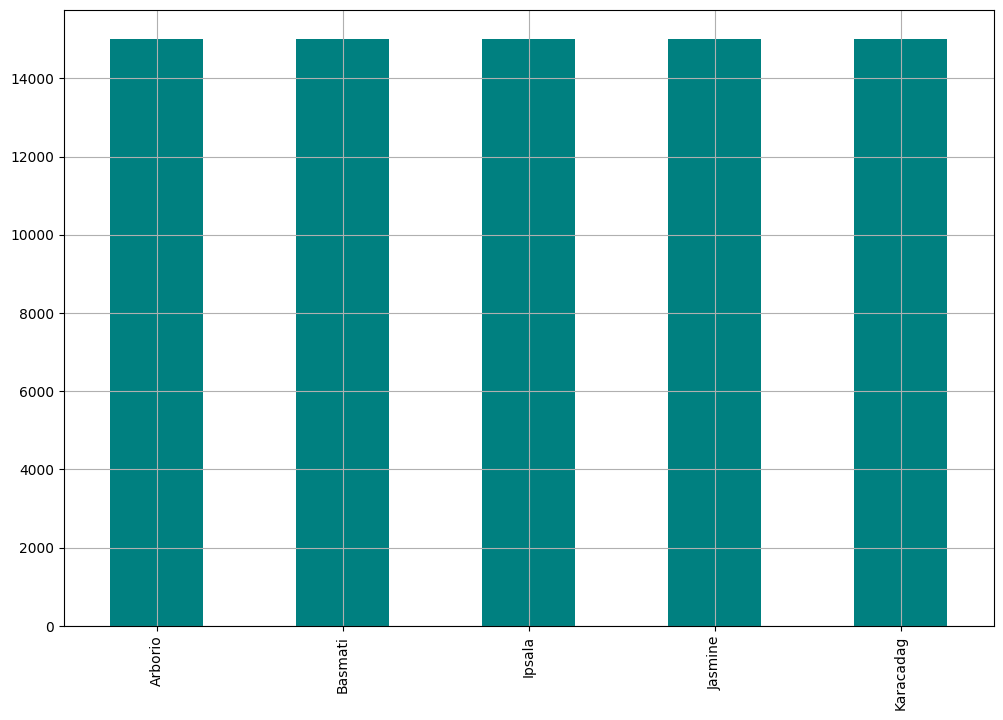

In [5]:
df.name.value_counts().plot(kind='bar',figsize = (12,8), grid = True, color = 'teal')

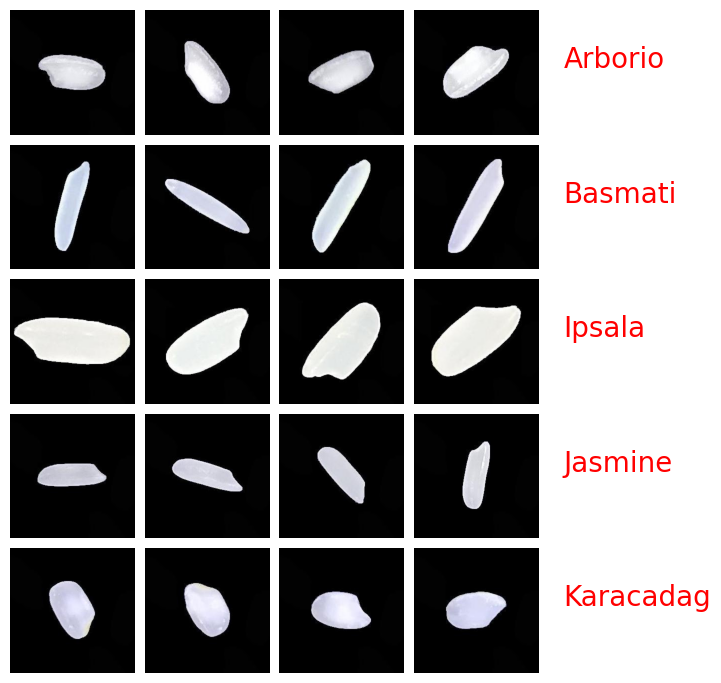

In [6]:
fig=plt.figure(1,figsize=(15,15))
grid=ImageGrid(fig,121, nrows_ncols=(5, 4), axes_pad=0.10)
i=0
for category_id, category in enumerate(df.name.unique()):
    for filepath in df[df['name'] == category]['link'].values[:4]:
        ax = grid[i]
        img=Image.open(filepath)
        ax.imshow(img)
        ax.axis('off')
        if i % 4 == 4 - 1:
            ax.text(300, 100, category, verticalalignment='center',fontsize=20,color = 'red')
        i+=1
        
plt.show()

In [7]:
def Load_Images(impath):
    imgs = []
    label = []
    l1 = os.listdir(impath)
    l1.remove('Rice_Citation_Request.txt')
    for i in l1:
        l2 = os.listdir(impath + '/' + i)
        for j in l2[:3000]:
            c = 0
            img = Image.open(impath + i + '/' + j)
            img = img.resize(size = (28,28))
            img = img.convert('L')
            #img=np.array(img,dtype=np.float16)/255
            imgs.append(np.array(img).flatten())
            label.append(i)
            del img
    return np.array(imgs),label

In [11]:
x, y = Load_Images('Rice_Image_Dataset/')

In [12]:
x.shape, len(y)

((15000, 784), 15000)

In [13]:
a = pd.Series(y, dtype = 'category')
a

0          Arborio
1          Arborio
2          Arborio
3          Arborio
4          Arborio
           ...    
14995    Karacadag
14996    Karacadag
14997    Karacadag
14998    Karacadag
14999    Karacadag
Length: 15000, dtype: category
Categories (5, object): ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [14]:
a.value_counts()

Arborio      3000
Basmati      3000
Ipsala       3000
Jasmine      3000
Karacadag    3000
dtype: int64

In [15]:
b = a.cat.codes
b

0        0
1        0
2        0
3        0
4        0
        ..
14995    4
14996    4
14997    4
14998    4
14999    4
Length: 15000, dtype: int8

In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x ,b, test_size = 0.2, shuffle = True,random_state=53)
# # X= train_test_split(x ,b, test_size = 0.2, shuffle = True)
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

# Tạo tập Train, Test, Val

In [16]:
vitri=np.random.permutation(15000)

In [17]:
vitri_train=vitri[:12000]
vitri_test=vitri[12000:13500]
vitri_val=vitri[13500:]

In [18]:
x_train=np.array([x[i] for i in vitri_train])
y_train=np.array([b[i] for i in vitri_train])

x_test=np.array([x[i] for i in vitri_test])
y_test=np.array([b[i] for i in vitri_test])

x_val=np.array([x[i] for i in vitri_val])
y_val=np.array([b[i] for i in vitri_val])

In [19]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape ,x_val.shape, y_val.shape

((12000, 784), (1500, 784), (12000,), (1500,), (1500, 784), (1500,))

# Lan truyền tiến

![image](forward.jpg)

# Lan truyền ngược

![image](backward_detail.jpg)

- Mục tiêu của backward propagation là update lại weight và bias của các noron trong mạng
- ta thực hiện update weight bằng cách: weight_new= weight_curr - (đạo hàm của hàm cost theo weight ở chỗ cần update rồi nhân với learning_rate) (theo quy tắc chuỗi)


- Nguyên tắc:
    - Trước tiên ta tính loss của lớp output và chuyển kết quả đó cho lớn Hidden trước đó.
    - Sau khi tính toán loss lớp ẩn, chúng ta chuyển giá trị của nó trở lại lớp ẩn trước nữa

Để tính toán loss của lớp đầu ra, ta cần tìm đọa hàm của hàm cost đối với đầu vào của lớp đầu ra (Z0)

Để tính toán loss của lớp ẩn, chúng ta cần tìm đạo hàm của cost với đầu vào của lớp ẩn Zh

E0: là lỗi của lớp đầu ra

O: output (dự đoán)

y: lable thực có trước

Z0: Đầu vào của lớp đầu ra đó

R'(Z0): là đạo hàm của hàm kích hoạt

Tính toán lỗi hiện tại và chuyển lỗi có weight trở lại lớp trước, tiếp tục quá trình cho đến khi đến được lớp ẩn đầu tiên. trên đường đi thì cập nhật lại các weight và bias

# Công thức và đạo hàm của hàm kích hoạt

![image](activation.png)

In [24]:
np.random.seed(42)

class Layer:
    def __init__(self):
        self.weights = None
        self.bias = None
        pass
    
    def forward(self, input):
        output = np.matmul(input, self.weights) + self.bias
        return output
    
# Mỗi nơ-ron có một lớp được kết nối với mọi nơ-ron trong lớp ngay sau nó.
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.01):
        self.learning_rate = learning_rate
        
        # khỏi tạo weights và biases ngẫu nhiên
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.random.randn(output_units)*0.01
    
    # lan truyền tiến
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
    # lan truyền ngược
    def backward(self,input,grad_output):

        grad_input = np.dot(grad_output,self.weights.T)

        
        grad_weights =np.dot(grad_output.T,input).T
        grad_biases = np.sum(grad_output, axis = 0)
        
        # cập nhật lại weight và biases
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):

        return np.maximum(0,input)

    def backward(self, input, grad_output):

        relu_grad = input > 0
        return grad_output*relu_grad 


class Softmax(Layer):
    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.exp(input - np.max(input, axis = 0, keepdims = True)) / np.sum(np.exp(input), axis=0)
        return self.output

    def backward(self,input,output_grad):
        input_grad = self.output * (output_grad - np.sum(output_grad * self.output, axis=0, keepdims=True))
        return input_grad

# hàm mất mát này thường được sử dụng cùng với softmax để huấn luyện mạng
def softmax_crossentropy_with_logits(y_hat_logits,y):

    y_hat_logits_for_answers = y_hat_logits[np.arange(len(y_hat_logits)),y]
    
    xentropy = - y_hat_logits_for_answers + np.log(np.sum(np.exp(y_hat_logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(y_hat_logits,y):

    ones_for_answers = np.zeros_like(y_hat_logits)
    ones_for_answers[np.arange(len(y_hat_logits)),y] = 1
    
    softmax = np.exp(y_hat_logits) / np.exp(y_hat_logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / y_hat_logits.shape[0]

class SoftMax(Layer):
    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, input):
        return np.maximum(0,input)

    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad 

def forward(network, X):
    """
    Tính hàm kích hoạt của tất cả các lớp bằng cách áp dụng chúng một cách tuần tự.
    Trả về danh sách kích hoạt cho mỗi lớp.
    """
    activations = []
    
    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Dự đoán đầu ra
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)


def train(network,X,y):
    
    # Dự đoán Xtrain[i] => đưa ra layer_activations
    layer_activations = forward(network,X)
    
    # Lấy dự đoán cuối cùng
    y_hat_logits = layer_activations[-1]
    
    # tính toán loss
    loss = softmax_crossentropy_with_logits(y_hat_logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(y_hat_logits,y)

    
    for i in range(1, len(network)):
        loss_grad = network[len(network) - i].backward(layer_activations[len(network) - i - 1], loss_grad)
    
    return np.mean(loss)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [27]:
network = []
network.append(Dense(x_train.shape[1],256))
network.append(ReLU())
network.append(Dense(256,128))
network.append(ReLU())
network.append(Dense(128,64))
network.append(ReLU())
network.append(Dense(64,32))
network.append(SoftMax())
network.append(Dense(32,5))

train_log = []
val_log = []
train_loss=[]
val_loss=[]
epochs=100
for epoch in range(epochs):
    tloss=[]
    vloss=[]
    print(f"epoch: {epoch+1}/{epochs}")
    
    for x_batch,y_batch in iterate_minibatches(x_train,y_train,batchsize=32,shuffle=True):
        train_lf=train(network,x_batch,y_batch)
        tloss.append(train_lf)
        
    for x_batch,y_batch in iterate_minibatches(x_val,y_val,batchsize=32,shuffle=True):
        val_lf=train(network,x_batch,y_batch)
        vloss.append(val_lf)
        
    train_loss.append(sum(tloss)/len(tloss))
    print(f"Train Loss: {train_loss[-1]}")
    
    val_loss.append(sum(vloss)/len(vloss))
    print(f"Val Loss: {val_loss[-1]}")
    
    train_log.append(np.mean(predict(network,x_train)==y_train))
    print(f"Train Accuracy: {train_log[-1]}")
    val_log.append(np.mean(predict(network,x_val)==y_val))
    print(f"Val Accuracy: {val_log[-1]}")

epoch: 1/100


100%|██████████| 46/46 [00:00<00:00, 111.14it/s]


Train Loss: 1.6092864245526088
Val Loss: 1.6087815313067262
Train Accuracy: 0.3869166666666667
Val Accuracy: 0.4
epoch: 2/100


100%|██████████| 46/46 [00:00<00:00, 132.54it/s]


Train Loss: 1.601183913426675
Val Loss: 1.4895299884689843
Train Accuracy: 0.25433333333333336
Val Accuracy: 0.26066666666666666
epoch: 3/100


100%|██████████| 46/46 [00:00<00:00, 238.98it/s]


Train Loss: 1.049542713200367
Val Loss: 0.8085764859389674
Train Accuracy: 0.7556666666666667
Val Accuracy: 0.772
epoch: 4/100


100%|██████████| 46/46 [00:00<00:00, 234.12it/s]


Train Loss: 0.5542549386636547
Val Loss: 0.4789534971621687
Train Accuracy: 0.773
Val Accuracy: 0.7953333333333333
epoch: 5/100


100%|██████████| 46/46 [00:00<00:00, 93.18it/s] 


Train Loss: 0.4261161533974286
Val Loss: 0.34727024996404887
Train Accuracy: 0.7848333333333334
Val Accuracy: 0.7646666666666667
epoch: 6/100


100%|██████████| 46/46 [00:00<00:00, 64.05it/s]


Train Loss: 0.33736404667492503
Val Loss: 0.22450806287746716
Train Accuracy: 0.9339166666666666
Val Accuracy: 0.938
epoch: 7/100


100%|██████████| 46/46 [00:01<00:00, 41.25it/s]


Train Loss: 0.2864779976503413
Val Loss: 0.19790037502342817
Train Accuracy: 0.9250833333333334
Val Accuracy: 0.9406666666666667
epoch: 8/100


100%|██████████| 46/46 [00:00<00:00, 48.60it/s]


Train Loss: 0.23929375546552706
Val Loss: 0.25429444746096747
Train Accuracy: 0.9520833333333333
Val Accuracy: 0.968
epoch: 9/100


100%|██████████| 46/46 [00:00<00:00, 116.77it/s]


Train Loss: 0.2248128567409411
Val Loss: 0.16408209584320121
Train Accuracy: 0.9584166666666667
Val Accuracy: 0.9713333333333334
epoch: 10/100


100%|██████████| 46/46 [00:00<00:00, 56.59it/s]


Train Loss: 0.18204121125144118
Val Loss: 0.13685171561966397
Train Accuracy: 0.955
Val Accuracy: 0.9693333333333334
epoch: 11/100


100%|██████████| 46/46 [00:00<00:00, 127.76it/s]


Train Loss: 0.18142328214461667
Val Loss: 0.1245676522799977
Train Accuracy: 0.9615
Val Accuracy: 0.9726666666666667
epoch: 12/100


100%|██████████| 46/46 [00:00<00:00, 145.04it/s]


Train Loss: 0.14277416082525687
Val Loss: 0.10939603478228162
Train Accuracy: 0.96075
Val Accuracy: 0.9653333333333334
epoch: 13/100


100%|██████████| 46/46 [00:00<00:00, 178.77it/s]


Train Loss: 0.1422763732564956
Val Loss: 0.0977747343522786
Train Accuracy: 0.9595
Val Accuracy: 0.978
epoch: 14/100


100%|██████████| 46/46 [00:00<00:00, 186.73it/s]


Train Loss: 0.1237277232355883
Val Loss: 0.10448912594283966
Train Accuracy: 0.8183333333333334
Val Accuracy: 0.8253333333333334
epoch: 15/100


100%|██████████| 46/46 [00:00<00:00, 93.56it/s] 


Train Loss: 0.12475356355167821
Val Loss: 0.09611511815938502
Train Accuracy: 0.96725
Val Accuracy: 0.9766666666666667
epoch: 16/100


100%|██████████| 46/46 [00:00<00:00, 219.63it/s]


Train Loss: 0.11994762053024215
Val Loss: 0.08818500207699179
Train Accuracy: 0.9673333333333334
Val Accuracy: 0.976
epoch: 17/100


100%|██████████| 46/46 [00:00<00:00, 222.82it/s]


Train Loss: 0.111947990922813
Val Loss: 0.09353600249758762
Train Accuracy: 0.9670833333333333
Val Accuracy: 0.9793333333333333
epoch: 18/100


100%|██████████| 46/46 [00:00<00:00, 165.32it/s]


Train Loss: 0.11150208928128381
Val Loss: 0.07936136775783088
Train Accuracy: 0.9714166666666667
Val Accuracy: 0.9806666666666667
epoch: 19/100


100%|██████████| 46/46 [00:00<00:00, 220.69it/s]


Train Loss: 0.11477799836431928
Val Loss: 0.08178021828219649
Train Accuracy: 0.9680833333333333
Val Accuracy: 0.9773333333333334
epoch: 20/100


100%|██████████| 46/46 [00:00<00:00, 235.32it/s]


Train Loss: 0.10271052994243318
Val Loss: 0.07960045253120317
Train Accuracy: 0.97325
Val Accuracy: 0.9813333333333333
epoch: 21/100


100%|██████████| 46/46 [00:00<00:00, 238.98it/s]


Train Loss: 0.10062368474795776
Val Loss: 0.0764334310866343
Train Accuracy: 0.9700833333333333
Val Accuracy: 0.982
epoch: 22/100


100%|██████████| 46/46 [00:00<00:00, 159.04it/s]


Train Loss: 0.10047029068670205
Val Loss: 0.08392535013233228
Train Accuracy: 0.96925
Val Accuracy: 0.9806666666666667
epoch: 23/100


100%|██████████| 46/46 [00:00<00:00, 229.47it/s]


Train Loss: 0.09761748492308067
Val Loss: 0.06676030534068822
Train Accuracy: 0.9659166666666666
Val Accuracy: 0.9773333333333334
epoch: 24/100


100%|██████████| 46/46 [00:00<00:00, 234.13it/s]


Train Loss: 0.09546367399222166
Val Loss: 0.0738539141612817
Train Accuracy: 0.9633333333333334
Val Accuracy: 0.978
epoch: 25/100


100%|██████████| 46/46 [00:00<00:00, 235.32it/s]


Train Loss: 0.09535929513484033
Val Loss: 0.06766590239807331
Train Accuracy: 0.9724166666666667
Val Accuracy: 0.9813333333333333
epoch: 26/100


100%|██████████| 46/46 [00:00<00:00, 254.83it/s]


Train Loss: 0.09598683851243468
Val Loss: 0.06874203434736983
Train Accuracy: 0.9279166666666666
Val Accuracy: 0.9353333333333333
epoch: 27/100


100%|██████████| 46/46 [00:00<00:00, 240.23it/s]


Train Loss: 0.09072845561083379
Val Loss: 0.07609083062910164
Train Accuracy: 0.9718333333333333
Val Accuracy: 0.9806666666666667
epoch: 28/100


100%|██████████| 46/46 [00:00<00:00, 231.77it/s]


Train Loss: 0.08935163209171927
Val Loss: 0.07120241290804645
Train Accuracy: 0.9739166666666667
Val Accuracy: 0.9833333333333333
epoch: 29/100


100%|██████████| 46/46 [00:00<00:00, 234.13it/s]


Train Loss: 0.08695391245850573
Val Loss: 0.06636404202168975
Train Accuracy: 0.9698333333333333
Val Accuracy: 0.98
epoch: 30/100


100%|██████████| 46/46 [00:00<00:00, 247.97it/s]


Train Loss: 0.08783947935844084
Val Loss: 0.06630737177243802
Train Accuracy: 0.97675
Val Accuracy: 0.9873333333333333
epoch: 31/100


100%|██████████| 46/46 [00:00<00:00, 241.48it/s]


Train Loss: 0.08279705660269225
Val Loss: 0.06721262519246482
Train Accuracy: 0.967
Val Accuracy: 0.9773333333333334
epoch: 32/100


100%|██████████| 46/46 [00:00<00:00, 244.04it/s]


Train Loss: 0.08836797327099219
Val Loss: 0.06431582099450127
Train Accuracy: 0.976
Val Accuracy: 0.9846666666666667
epoch: 33/100


100%|██████████| 46/46 [00:00<00:00, 250.67it/s]


Train Loss: 0.08410580868965835
Val Loss: 0.058299148663917714
Train Accuracy: 0.97725
Val Accuracy: 0.9866666666666667
epoch: 34/100


100%|██████████| 46/46 [00:00<00:00, 159.04it/s]


Train Loss: 0.08600235304799841
Val Loss: 0.06337824873938579
Train Accuracy: 0.97275
Val Accuracy: 0.9833333333333333
epoch: 35/100


100%|██████████| 46/46 [00:00<00:00, 176.04it/s]


Train Loss: 0.08465355652714827
Val Loss: 0.07412808812823526
Train Accuracy: 0.9705833333333334
Val Accuracy: 0.9813333333333333
epoch: 36/100


100%|██████████| 46/46 [00:00<00:00, 230.62it/s]


Train Loss: 0.08135293996392755
Val Loss: 0.07506701519775623
Train Accuracy: 0.9775
Val Accuracy: 0.9873333333333333
epoch: 37/100


100%|██████████| 46/46 [00:00<00:00, 247.98it/s]


Train Loss: 0.07952517814805407
Val Loss: 0.06171813187808948
Train Accuracy: 0.9771666666666666
Val Accuracy: 0.9846666666666667
epoch: 38/100


100%|██████████| 46/46 [00:00<00:00, 218.59it/s]


Train Loss: 0.077198829689193
Val Loss: 0.05818814361754661
Train Accuracy: 0.9756666666666667
Val Accuracy: 0.9866666666666667
epoch: 39/100


100%|██████████| 46/46 [00:00<00:00, 180.87it/s]


Train Loss: 0.07761904889295426
Val Loss: 0.05384722181778446
Train Accuracy: 0.9775833333333334
Val Accuracy: 0.9853333333333333
epoch: 40/100


100%|██████████| 46/46 [00:00<00:00, 174.05it/s]


Train Loss: 0.0756805760617659
Val Loss: 0.05562764029244439
Train Accuracy: 0.9789166666666667
Val Accuracy: 0.986
epoch: 41/100


100%|██████████| 46/46 [00:00<00:00, 199.67it/s]


Train Loss: 0.07563879853166901
Val Loss: 0.056526142128480894
Train Accuracy: 0.9748333333333333
Val Accuracy: 0.9826666666666667
epoch: 42/100


100%|██████████| 46/46 [00:00<00:00, 234.13it/s]


Train Loss: 0.07487307351688723
Val Loss: 0.058541848178822666
Train Accuracy: 0.9658333333333333
Val Accuracy: 0.974
epoch: 43/100


100%|██████████| 46/46 [00:00<00:00, 254.82it/s]


Train Loss: 0.07195584192368014
Val Loss: 0.05205233263501361
Train Accuracy: 0.9775
Val Accuracy: 0.9833333333333333
epoch: 44/100


100%|██████████| 46/46 [00:00<00:00, 229.47it/s]


Train Loss: 0.06925592721262201
Val Loss: 0.05628827087198853
Train Accuracy: 0.96775
Val Accuracy: 0.9793333333333333
epoch: 45/100


100%|██████████| 46/46 [00:00<00:00, 228.33it/s]


Train Loss: 0.07693895982985727
Val Loss: 0.05969109720977824
Train Accuracy: 0.9779166666666667
Val Accuracy: 0.986
epoch: 46/100


100%|██████████| 46/46 [00:00<00:00, 244.03it/s]


Train Loss: 0.07273558686373795
Val Loss: 0.04802333755658715
Train Accuracy: 0.9808333333333333
Val Accuracy: 0.9893333333333333
epoch: 47/100


100%|██████████| 46/46 [00:00<00:00, 232.95it/s]


Train Loss: 0.0663391689035869
Val Loss: 0.06100526003248469
Train Accuracy: 0.9784166666666667
Val Accuracy: 0.9886666666666667
epoch: 48/100


100%|██████████| 46/46 [00:00<00:00, 234.13it/s]


Train Loss: 0.07046701209677336
Val Loss: 0.057749284422607426
Train Accuracy: 0.9766666666666667
Val Accuracy: 0.9846666666666667
epoch: 49/100


100%|██████████| 46/46 [00:00<00:00, 199.66it/s]


Train Loss: 0.07016495702936697
Val Loss: 0.051590860804913645
Train Accuracy: 0.9716666666666667
Val Accuracy: 0.9793333333333333
epoch: 50/100


100%|██████████| 46/46 [00:00<00:00, 236.53it/s]


Train Loss: 0.06898495496317701
Val Loss: 0.053919562214202556
Train Accuracy: 0.9795
Val Accuracy: 0.9866666666666667
epoch: 51/100


100%|██████████| 46/46 [00:00<00:00, 134.08it/s]


Train Loss: 0.06791441630402768
Val Loss: 0.04340217783653453
Train Accuracy: 0.9789166666666667
Val Accuracy: 0.9873333333333333
epoch: 52/100


100%|██████████| 46/46 [00:00<00:00, 138.92it/s]


Train Loss: 0.07129979079669117
Val Loss: 0.053326153098779465
Train Accuracy: 0.9809166666666667
Val Accuracy: 0.988
epoch: 53/100


100%|██████████| 46/46 [00:00<00:00, 122.67it/s]


Train Loss: 0.06632034526997556
Val Loss: 0.047903228097016096
Train Accuracy: 0.981
Val Accuracy: 0.988
epoch: 54/100


100%|██████████| 46/46 [00:00<00:00, 173.39it/s]


Train Loss: 0.06832820687659293
Val Loss: 0.047399406290622274
Train Accuracy: 0.9729166666666667
Val Accuracy: 0.984
epoch: 55/100


100%|██████████| 46/46 [00:00<00:00, 211.57it/s]


Train Loss: 0.06099069463673526
Val Loss: 0.05296392650259388
Train Accuracy: 0.9808333333333333
Val Accuracy: 0.986
epoch: 56/100


100%|██████████| 46/46 [00:00<00:00, 133.39it/s]


Train Loss: 0.06506564283522491
Val Loss: 0.051782308067712744
Train Accuracy: 0.9805833333333334
Val Accuracy: 0.99
epoch: 57/100


100%|██████████| 46/46 [00:00<00:00, 159.04it/s]


Train Loss: 0.061186677868779855
Val Loss: 0.056314408557163895
Train Accuracy: 0.98
Val Accuracy: 0.9893333333333333
epoch: 58/100


100%|██████████| 46/46 [00:00<00:00, 185.23it/s]


Train Loss: 0.062095194436804224
Val Loss: 0.045527180321756684
Train Accuracy: 0.97725
Val Accuracy: 0.988
epoch: 59/100


100%|██████████| 46/46 [00:00<00:00, 121.70it/s]


Train Loss: 0.0696286613260113
Val Loss: 0.04613321730891058
Train Accuracy: 0.9806666666666667
Val Accuracy: 0.9893333333333333
epoch: 60/100


100%|██████████| 46/46 [00:00<00:00, 153.75it/s]


Train Loss: 0.061443408655293213
Val Loss: 0.045316393073696316
Train Accuracy: 0.9800833333333333
Val Accuracy: 0.992
epoch: 61/100


100%|██████████| 46/46 [00:00<00:00, 217.50it/s]


Train Loss: 0.05987535888509736
Val Loss: 0.0415920068962303
Train Accuracy: 0.9755
Val Accuracy: 0.984
epoch: 62/100


100%|██████████| 46/46 [00:00<00:00, 203.54it/s]


Train Loss: 0.06294672415979007
Val Loss: 0.04888952422907192
Train Accuracy: 0.9824166666666667
Val Accuracy: 0.992
epoch: 63/100


100%|██████████| 46/46 [00:00<00:00, 140.35it/s]


Train Loss: 0.06396082903276541
Val Loss: 0.049902067036831844
Train Accuracy: 0.98325
Val Accuracy: 0.9906666666666667
epoch: 64/100


100%|██████████| 46/46 [00:00<00:00, 189.81it/s]


Train Loss: 0.060773992144892465
Val Loss: 0.04809946907954256
Train Accuracy: 0.9826666666666667
Val Accuracy: 0.9886666666666667
epoch: 65/100


100%|██████████| 46/46 [00:00<00:00, 167.72it/s]


Train Loss: 0.06209946227333281
Val Loss: 0.05035575095906817
Train Accuracy: 0.9795833333333334
Val Accuracy: 0.9893333333333333
epoch: 66/100


100%|██████████| 46/46 [00:00<00:00, 222.82it/s]


Train Loss: 0.06206587201165622
Val Loss: 0.04549237885159016
Train Accuracy: 0.9789166666666667
Val Accuracy: 0.988
epoch: 67/100


100%|██████████| 46/46 [00:00<00:00, 106.52it/s]


Train Loss: 0.05859535513879147
Val Loss: 0.05013675826401231
Train Accuracy: 0.9814166666666667
Val Accuracy: 0.9913333333333333
epoch: 68/100


100%|██████████| 46/46 [00:00<00:00, 234.12it/s]


Train Loss: 0.05984722635594765
Val Loss: 0.0456464972731526
Train Accuracy: 0.9844166666666667
Val Accuracy: 0.9906666666666667
epoch: 69/100


100%|██████████| 46/46 [00:00<00:00, 229.47it/s]


Train Loss: 0.058474837809931395
Val Loss: 0.044100361948061745
Train Accuracy: 0.9835833333333334
Val Accuracy: 0.9913333333333333
epoch: 70/100


100%|██████████| 46/46 [00:00<00:00, 235.32it/s]


Train Loss: 0.05830790408527323
Val Loss: 0.0458388715171276
Train Accuracy: 0.9836666666666667
Val Accuracy: 0.99
epoch: 71/100


100%|██████████| 46/46 [00:00<00:00, 182.30it/s]


Train Loss: 0.05885088765465198
Val Loss: 0.04037795765110864
Train Accuracy: 0.9794166666666667
Val Accuracy: 0.9913333333333333
epoch: 72/100


100%|██████████| 46/46 [00:00<00:00, 164.73it/s]


Train Loss: 0.05665850673316639
Val Loss: 0.042364005662356576
Train Accuracy: 0.9796666666666667
Val Accuracy: 0.9893333333333333
epoch: 73/100


100%|██████████| 46/46 [00:00<00:00, 90.97it/s]


Train Loss: 0.05462568502403955
Val Loss: 0.037642940089974236
Train Accuracy: 0.9801666666666666
Val Accuracy: 0.9846666666666667
epoch: 74/100


100%|██████████| 46/46 [00:01<00:00, 27.04it/s]


Train Loss: 0.05570099572416305
Val Loss: 0.04268113741863032
Train Accuracy: 0.9856666666666667
Val Accuracy: 0.9906666666666667
epoch: 75/100


100%|██████████| 46/46 [00:00<00:00, 204.08it/s]


Train Loss: 0.058184291881855706
Val Loss: 0.04328536123433526
Train Accuracy: 0.9806666666666667
Val Accuracy: 0.9913333333333333
epoch: 76/100


100%|██████████| 46/46 [00:00<00:00, 97.51it/s] 


Train Loss: 0.05768849185816959
Val Loss: 0.042974943611226814
Train Accuracy: 0.9848333333333333
Val Accuracy: 0.992
epoch: 77/100


100%|██████████| 46/46 [00:00<00:00, 131.03it/s]


Train Loss: 0.05276722957276941
Val Loss: 0.05189138166555409
Train Accuracy: 0.9844166666666667
Val Accuracy: 0.9933333333333333
epoch: 78/100


100%|██████████| 46/46 [00:00<00:00, 106.03it/s]


Train Loss: 0.05198943362102148
Val Loss: 0.03775768905892434
Train Accuracy: 0.986
Val Accuracy: 0.994
epoch: 79/100


100%|██████████| 46/46 [00:00<00:00, 88.70it/s] 


Train Loss: 0.05365749263767928
Val Loss: 0.038203714982001195
Train Accuracy: 0.9849166666666667
Val Accuracy: 0.9926666666666667
epoch: 80/100


100%|██████████| 46/46 [00:00<00:00, 205.91it/s]


Train Loss: 0.0557049661350572
Val Loss: 0.03803878790392314
Train Accuracy: 0.9831666666666666
Val Accuracy: 0.99
epoch: 81/100


100%|██████████| 46/46 [00:00<00:00, 232.94it/s]


Train Loss: 0.050399728391858
Val Loss: 0.042236869580279904
Train Accuracy: 0.9800833333333333
Val Accuracy: 0.9893333333333333
epoch: 82/100


100%|██████████| 46/46 [00:00<00:00, 216.54it/s]


Train Loss: 0.05287269392216582
Val Loss: 0.031873459242333084
Train Accuracy: 0.9830833333333333
Val Accuracy: 0.9906666666666667
epoch: 83/100


100%|██████████| 46/46 [00:00<00:00, 231.77it/s]


Train Loss: 0.05204364665202939
Val Loss: 0.03700309729992004
Train Accuracy: 0.984
Val Accuracy: 0.9926666666666667
epoch: 84/100


100%|██████████| 46/46 [00:00<00:00, 130.29it/s]


Train Loss: 0.0491457061331215
Val Loss: 0.03915566271369101
Train Accuracy: 0.98225
Val Accuracy: 0.9893333333333333
epoch: 85/100


100%|██████████| 46/46 [00:00<00:00, 218.59it/s]


Train Loss: 0.04924981135415033
Val Loss: 0.036335205879286424
Train Accuracy: 0.9839166666666667
Val Accuracy: 0.9926666666666667
epoch: 86/100


100%|██████████| 46/46 [00:00<00:00, 232.94it/s]


Train Loss: 0.04717284015999909
Val Loss: 0.035820606934492835
Train Accuracy: 0.9874166666666667
Val Accuracy: 0.994
epoch: 87/100


100%|██████████| 46/46 [00:00<00:00, 218.59it/s]


Train Loss: 0.049668102108322384
Val Loss: 0.04473565028463771
Train Accuracy: 0.9856666666666667
Val Accuracy: 0.9913333333333333
epoch: 88/100


100%|██████████| 46/46 [00:00<00:00, 219.63it/s]


Train Loss: 0.05305725771265741
Val Loss: 0.0386364980322082
Train Accuracy: 0.98675
Val Accuracy: 0.9926666666666667
epoch: 89/100


100%|██████████| 46/46 [00:00<00:00, 221.75it/s]


Train Loss: 0.05132536187083913
Val Loss: 0.04076830659620227
Train Accuracy: 0.9835
Val Accuracy: 0.9886666666666667
epoch: 90/100


100%|██████████| 46/46 [00:00<00:00, 146.42it/s]


Train Loss: 0.04952971692893779
Val Loss: 0.03082620438544031
Train Accuracy: 0.9760833333333333
Val Accuracy: 0.9833333333333333
epoch: 91/100


100%|██████████| 46/46 [00:00<00:00, 237.75it/s]


Train Loss: 0.048378718154635465
Val Loss: 0.036017298439757754
Train Accuracy: 0.9804166666666667
Val Accuracy: 0.988
epoch: 92/100


100%|██████████| 46/46 [00:00<00:00, 228.33it/s]


Train Loss: 0.04413741976062893
Val Loss: 0.036768428252974224
Train Accuracy: 0.9856666666666667
Val Accuracy: 0.9933333333333333
epoch: 93/100


100%|██████████| 46/46 [00:00<00:00, 229.47it/s]


Train Loss: 0.04473889613413266
Val Loss: 0.03930033126228519
Train Accuracy: 0.9864166666666667
Val Accuracy: 0.9933333333333333
epoch: 94/100


100%|██████████| 46/46 [00:00<00:00, 228.33it/s]


Train Loss: 0.04711080207432895
Val Loss: 0.03373829487833802
Train Accuracy: 0.9864166666666667
Val Accuracy: 0.9946666666666667
epoch: 95/100


100%|██████████| 46/46 [00:00<00:00, 240.22it/s]


Train Loss: 0.04519394461303545
Val Loss: 0.03293675128149374
Train Accuracy: 0.9838333333333333
Val Accuracy: 0.9926666666666667
epoch: 96/100


100%|██████████| 46/46 [00:00<00:00, 230.61it/s]


Train Loss: 0.05073888301269443
Val Loss: 0.03330818969184547
Train Accuracy: 0.9894166666666667
Val Accuracy: 0.9933333333333333
epoch: 97/100


100%|██████████| 46/46 [00:00<00:00, 227.21it/s]


Train Loss: 0.04455452755740484
Val Loss: 0.03602960269474957
Train Accuracy: 0.9874166666666667
Val Accuracy: 0.994
epoch: 98/100


100%|██████████| 46/46 [00:00<00:00, 218.59it/s]


Train Loss: 0.04717855266329812
Val Loss: 0.034085196302539936
Train Accuracy: 0.9789166666666667
Val Accuracy: 0.9866666666666667
epoch: 99/100


100%|██████████| 46/46 [00:00<00:00, 217.57it/s]


Train Loss: 0.04293196829160726
Val Loss: 0.033090993620423365
Train Accuracy: 0.9875
Val Accuracy: 0.992
epoch: 100/100


100%|██████████| 46/46 [00:00<00:00, 224.99it/s]


Train Loss: 0.04244666636069723
Val Loss: 0.028732492664455104
Train Accuracy: 0.9848333333333333
Val Accuracy: 0.994


Epoch 100
Train accuracy: 0.9848333333333333
Val accuracy: 0.994


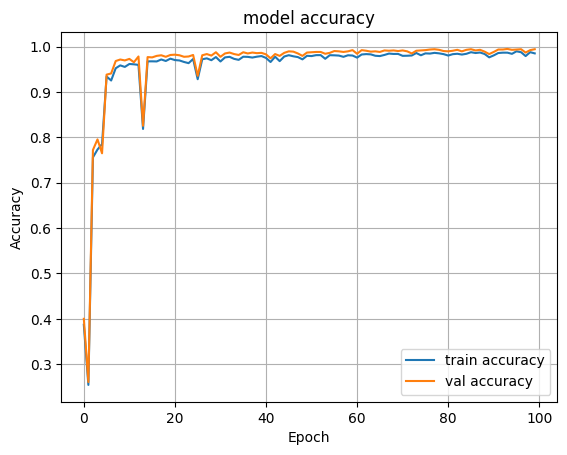

In [28]:
print("Epoch",epoch+1)
print("Train accuracy:",train_log[-1])
print("Val accuracy:", val_log[-1])
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.title("model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid()
plt.show()

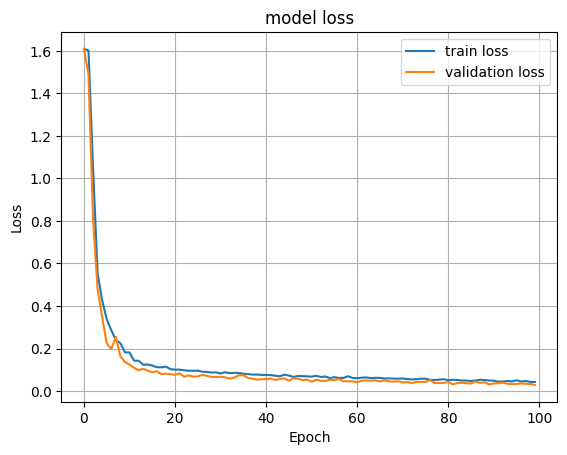

In [29]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='best')
plt.title("model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

97.6 %


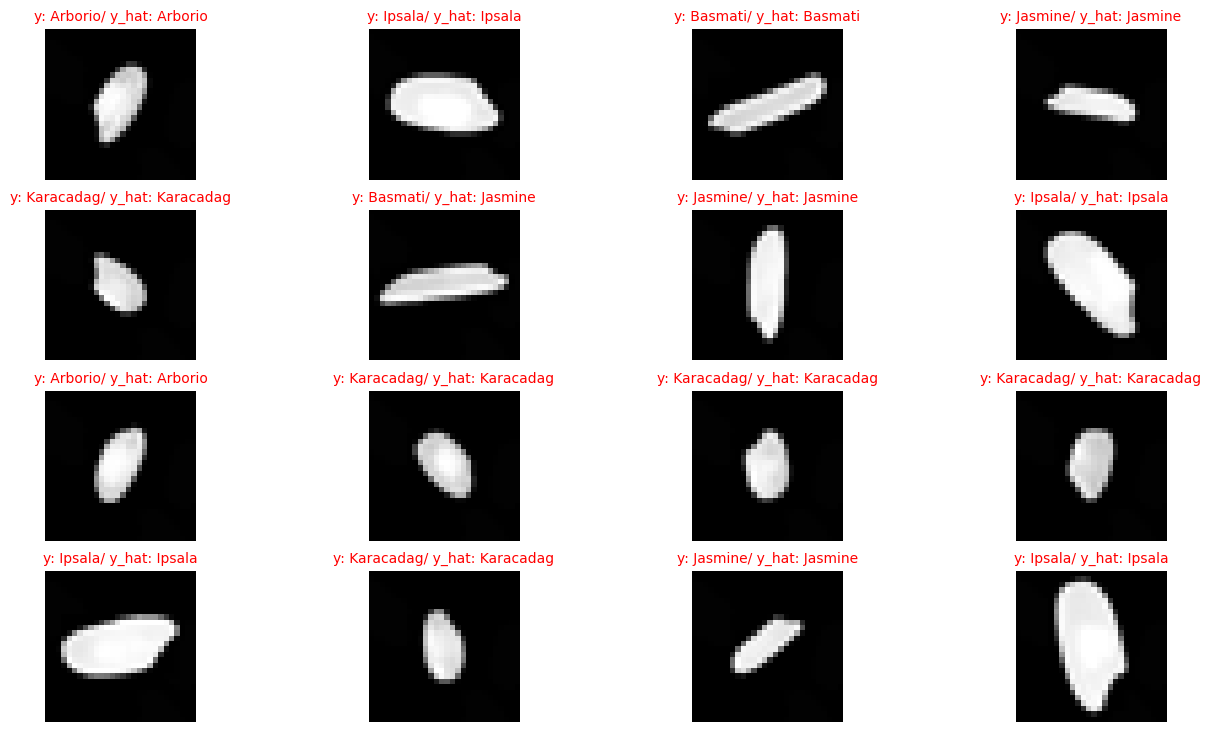

In [30]:
lb_pre=predict(network,x_test)
tenLb = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(len(y_test[lb_pre==y_test])/len(y_test) *100,"%")
fig=plt.figure(figsize=[16,9])
n=50
for i in range(16):
    ax=fig.add_subplot(4,4,i+1)
    ax.imshow(x_test[i+n].reshape([28,28]),cmap='gray')
    # plt.title(f"Label:{tenLb[lb_pre[i]]}")
    ax.set_title('y: {y}/ y_hat: {y_hat}'.format(y=tenLb[y_test[i+n]], y_hat=tenLb[lb_pre[i+n]]),fontsize=10,color='red')
    plt.axis('off')

In [31]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32,5), activation='relu', solver='adam', max_iter=500)
mlp.fit(x_train,y_train)

predict_train = mlp.predict(x_train)
predict_test = mlp.predict(x_test)

In [32]:
mlp.score(x_train,y_train)

0.20191666666666666

In [33]:
mlp.score(x_test,y_test)

0.19133333333333333